<a href="https://colab.research.google.com/github/djiraffs/Deep-Learning/blob/main/Week%204/Week_4_Tugas_GRU_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU MNIST Dataset pytorch

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = 28  # Each row of the image is treated as a sequence step
hidden_size = 128
num_layers = 2
num_classes = 10
learning_rate = 0.001
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, and optimizer
model = GRUModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        images = images.view(-1, 28, 28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()
y_true, y_pred, y_scores = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(-1, 28, 28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Simpan semua kelas

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
auc = roc_auc_score(y_true, y_scores, multi_class='ovr')

# Save results to CSV
results = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
    "Value": [accuracy, precision, recall, f1, auc]
})
results.to_csv("gru_pytorch_results.csv", index=False)

print("Evaluation results saved to gru_pytorch_results.csv")

100%|██████████| 9.91M/9.91M [00:00<00:00, 56.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.96MB/s]


Epoch [1/10], Loss: 0.2359
Epoch [2/10], Loss: 0.0127
Epoch [3/10], Loss: 0.0092
Epoch [4/10], Loss: 0.0136
Epoch [5/10], Loss: 0.0094
Epoch [6/10], Loss: 0.0051
Epoch [7/10], Loss: 0.0248
Epoch [8/10], Loss: 0.0225
Epoch [9/10], Loss: 0.0016
Epoch [10/10], Loss: 0.0980
Evaluation results saved to gru_pytorch_results.csv


# GRU MNIST dataset TensorFlow

In [4]:
!pip install tensorflow-datasets


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Reshape
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_auc_score
import pandas as pd
import tensorflow_datasets as tfds
import numpy as np

# 1. Memuat Dataset MNIST
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# 2. Pra-pemrosesan Data
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalisasi
    image = tf.reshape(image, (28, 28))  # Ubah bentuk menjadi (28, 28)
    return image, label

ds_train = ds_train.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(64).prefetch(tf.data.AUTOTUNE)

# 3. Membangun Model GRU
model = Sequential([
    Reshape((28, 28), input_shape=(28, 28)), # Reshape input
    GRU(64),
    Dense(10, activation='softmax')  # 10 kelas untuk MNIST
])

# 4. Kompilasi dan Melatih Model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(ds_train, epochs=5, validation_data=ds_test)

# 5. Evaluasi Model
y_pred_proba = model.predict(ds_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Perbaikan pengambilan label
y_test_labels_list = []
for _, y in ds_test.unbatch():
    y_test_labels_list.append(y.numpy())
y_test_labels = np.array(y_test_labels_list)

accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred, average='macro')
recall = recall_score(y_test_labels, y_pred, average='macro')
f1_squared = fbeta_score(y_test_labels, y_pred, average='macro', beta=2) # Perubahan disini

# Menggunakan One-Hot Encoding untuk menghitung AUC
y_test_one_hot = tf.keras.utils.to_categorical(y_test_labels, num_classes=10)
auc = roc_auc_score(y_test_one_hot, y_pred_proba, multi_class='ovr')

# 6. Menghitung ROC Curve (tidak relevan untuk multi-kelas)
# 7. Menyimpan Hasil Evaluasi ke CSV
results = {
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1_Squared': [f1_squared],
    'AUC': [auc]
}

df_results = pd.DataFrame(results)
df_results.to_csv('gru_tensorflow_results.csv', index=False)

# 8. Menampilkan Hasil Evaluasi
print("Hasil Evaluasi:")
print(df_results)

# 9. Menyimpan fpr dan tpr ke CSV (tidak relevan untuk multi-kelas)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.6081 - loss: 1.1126 - val_accuracy: 0.9310 - val_loss: 0.2239
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.9404 - loss: 0.2034 - val_accuracy: 0.9579 - val_loss: 0.1427
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9623 - loss: 0.1293 - val_accuracy: 0.9691 - val_loss: 0.1049
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9711 - loss: 0.0996 - val_accuracy: 0.9722 - val_loss: 0.0925
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9758 - loss: 0.0809 - val_accuracy: 0.9746 - val_loss: 0.0856
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Hasil Evaluasi:
   Accuracy  Precision    Recall  F1_Squared       AUC
0    0.9746   0.974774  0.974194    0.974255  0.999412


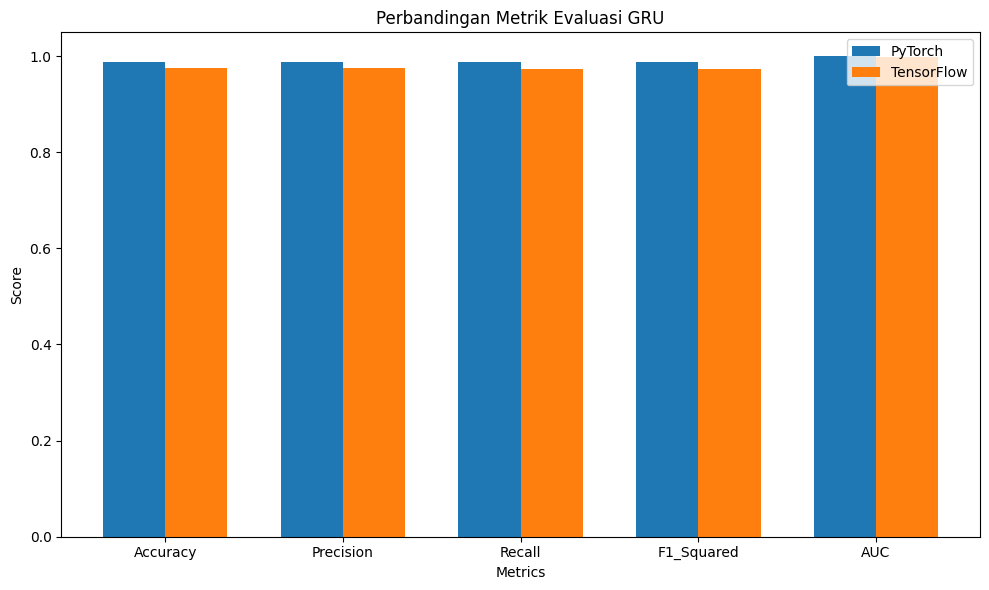

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Memuat hasil dari file CSV
pytorch_results = pd.read_csv('gru_pytorch_results.csv')
tensorflow_results = pd.read_csv('gru_tensorflow_results.csv')

# Metrik yang akan dibandingkan
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Squared', 'AUC']

# Mengambil nilai dari DataFrame PyTorch
pytorch_values = pytorch_results['Value'].tolist()

# Mengambil nilai dari DataFrame TensorFlow
tensorflow_values = tensorflow_results.iloc[0][metrics].tolist()

# Membuat grafik perbandingan
plt.figure(figsize=(10, 6))
x = range(len(metrics))
width = 0.35

plt.bar(x, pytorch_values, width, label='PyTorch')
plt.bar([i + width for i in x], tensorflow_values, width, label='TensorFlow')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Perbandingan Metrik Evaluasi GRU')
plt.xticks([i + width / 2 for i in x], metrics)
plt.legend()
plt.tight_layout()
plt.show()

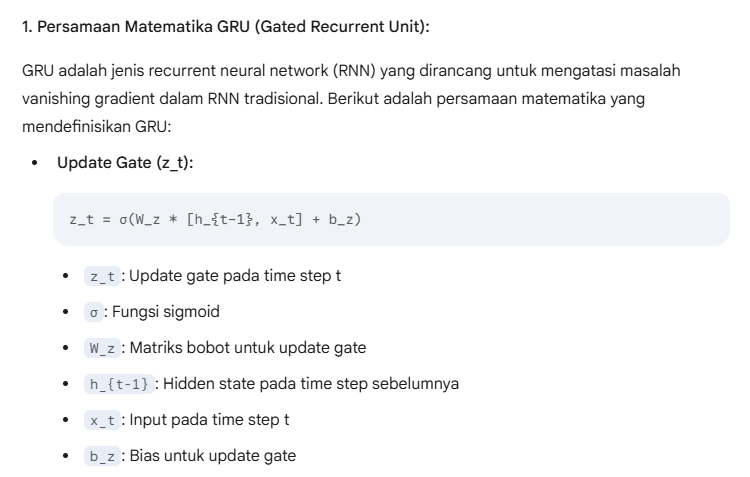

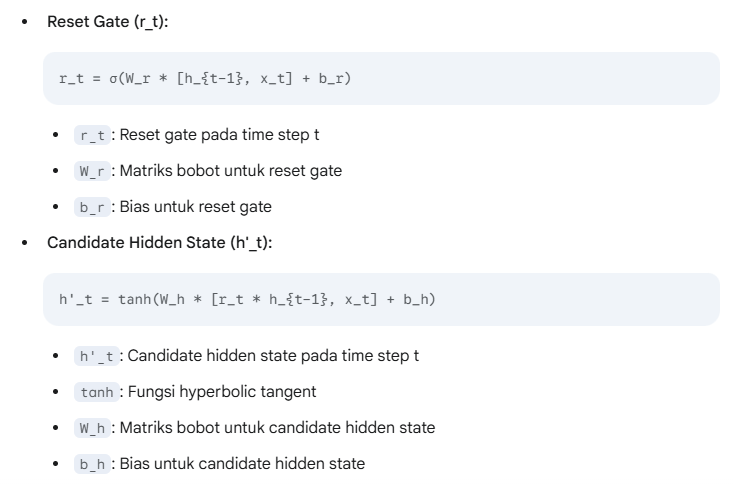

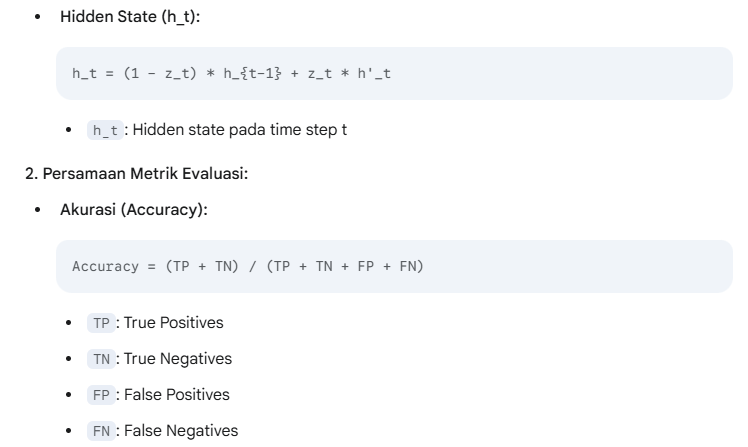

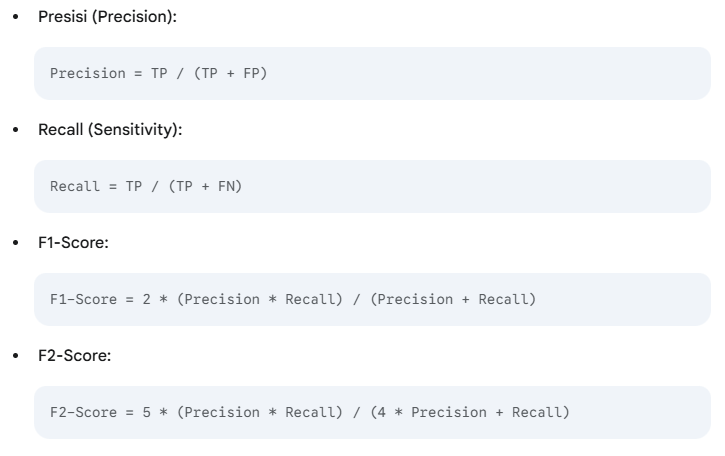

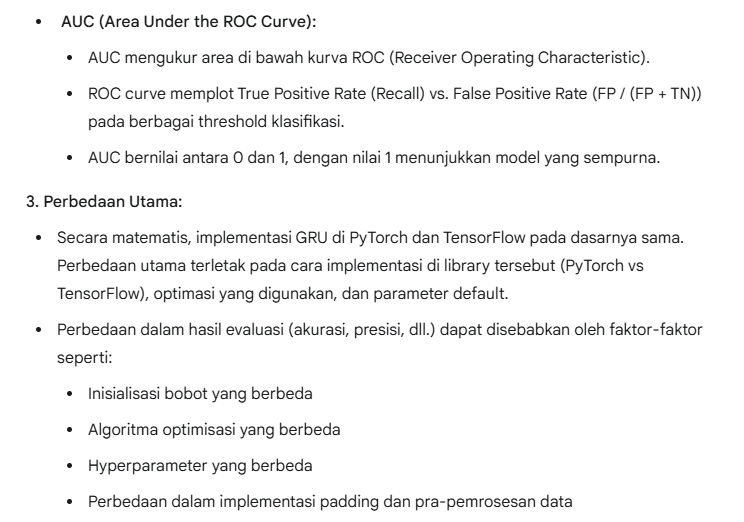